Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from flax import linen as nn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# choose GPU
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
jax.config.update("jax_enable_x64", True)

In [2]:
n_gpu = len(jax.devices())
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0)]

8. 6D Parametric Equation

        (u_xx + u_yy) + u*(1 - u**2) = g

In [3]:
# Function to generate analytical solution
@jit
def eval_u(x, y, a1, a2, w1, w2, w3, w4):
    u = a1 * jnp.tanh(w1*x) * jnp.tanh(w2*y) + a2 * jnp.sin(w3*x) * jnp.sin(w4*y)
    return u

# obtain g
@jit
def eval_g(x, y, a1, a2, w1, w2, w3, w4):
    u = a1 * jnp.tanh(w1*x) * jnp.tanh(w2*y) + a2 * jnp.sin(w3*x) * jnp.sin(w4*y)
    u_xx = -a2 *w3**2 *jnp.sin(w4*y) *jnp.sin(w3*x) - 2*a1 *w1**2 *jnp.tanh(w2*y) *(1/jnp.cosh(w1*x))**2 *jnp.tanh(w1*x)
    u_yy = -a2 *w4**2 *jnp.sin(w3*x) *jnp.sin(w4*y) - 2*a1 *w2**2 *jnp.tanh(w1*x) *(1/jnp.cosh(w2*y))**2 *jnp.tanh(w2*y)
    g = (u_xx + u_yy) + u*(1 - u**2)
    return g

x_l, x_u = -1, 1
y_l, y_u = -1, 1

# α ∈ [0.1, 1] and ω ∈ [1, 5]

In [4]:
# test set
seed = 1
key, rng = random.split(random.PRNGKey(seed))
key, rng = random.split(rng) # update random generator
test_task = jnp.hstack([random.uniform(key, (100, 2), minval=0.1, maxval=1),
                        random.uniform(key, (100, 4), minval=1, maxval=5)])

# train set
key, rng = random.split(rng) # update random generator
train_task = jnp.hstack([random.uniform(key, (17, 2), minval=0.1, maxval=1),
                        random.uniform(key, (17, 4), minval=1, maxval=5)])

n_task = len(train_task)
print(test_task.shape, train_task.shape, n_task)
#a1, a2, w1, w2, w3, w4 = test_set[0]

(100, 6) (17, 6) 17


#BC sample = 124


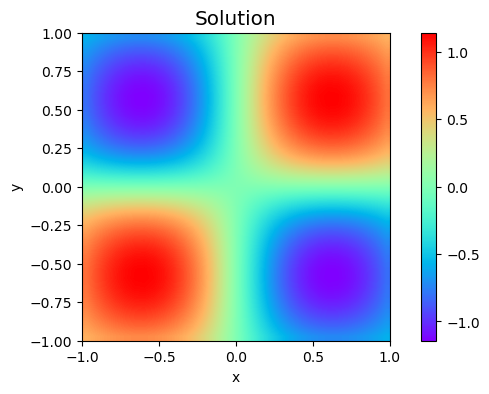

In [5]:
# train sample (32x32)
xs = jnp.linspace(-1, 1, 32)
ys = jnp.linspace(-1, 1, 32)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
xy_bc = ((x == x_l) | (x == x_u) | (y == y_l) | (y == y_u)).flatten()
print ('#BC sample = %d'%xy_bc.sum())

# plot 1
a1, a2, w1, w2, w3, w4 = train_task[0]
u = eval_u(x, y, a1, a2, w1, w2, w3, w4)

fig = plt.figure(figsize=(8, 4))
u_plot = u.reshape(32, -1)
ext = [x_l, x_u, y_l, y_u]     # plot boundary 
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.); 
plt.colorbar(mesh2); 
plt.xlabel('x'); plt.ylabel('y'); 
plt.title('Solution', fontsize='x-large'); 

Baldwinian PINN (B-PINN)

In [6]:
# construct randomization B-PINN for linear/nonlinear ODE/PDEs
@jit
def get_f(x, y, weights):
    f = jnp.hstack([jnp.sin(x * weights[0] + y * weights[1] + weights[2]),
                    nn.softplus(x * weights[3] + y * weights[4] + weights[5]),
                    jnp.tanh(x * weights[6] + y * weights[7] + weights[8]),
                    jnp.sin(x * weights[9] + y * weights[10] + weights[11]),
                    nn.softplus(x * weights[12] + y * weights[13] + weights[14]),
                    jnp.tanh(x * weights[15] + y * weights[16] + weights[17])])
    return f

# obtain f_dir
def get_f_dir(get_f, x, y, weights):
    #f_x, f_y = jacfwd(get_f)(x, y, weights), jacfwd(get_f, argnums=1)(x, y, weights)
    f_xx, f_yy = jacfwd(jacfwd(get_f))(x, y, weights), jacfwd(jacfwd(get_f, argnums=1), argnums=1)(x, y, weights)
    return f_xx, f_yy

f_vmap = vmap(get_f, in_axes=(0, 0, None))
f_dir_vmap = vmap(get_f_dir, in_axes=(None, 0, 0, None))

In [7]:
# no. neurons
n_node = 150

# generate weight & bias dist.
seed = 1
key, rng = random.split(random.PRNGKey(seed))
key, rng = random.split(rng) # update random generator
weights_n = random.truncated_normal(key, shape=(n_node, 9), lower=-1, upper=1)
key, rng = random.split(rng) # update random generator
weights_u = random.uniform(key, (n_node, 9), minval=-1, maxval=1)

# regularization
lamb = 1e-4

In [8]:
@jit
def compute_ssr_task(param, task):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # problem
    a1, a2, w1, w2, w3, w4 = train_task[task]
    u_bc = eval_u(x, y, a1, a2, w1, w2, w3, w4)
    #s_bc = ((x == x_l) | (x == x_u) | (y == y_l) | (y == y_u)).flatten()
    # PDE : (u_xx + u_yy) + u*(1 - u**2) = g
    f = f_vmap(x, y, weights)
    f_xx, f_yy = f_dir_vmap(get_f, x, y, weights)
    f_xx, f_yy = f_xx[:,:,0,0], f_yy[:,:,0,0]
    # first iteration - u0 = 0
    u0 = 0
    pde = (f_xx + f_yy) + f*(1 - u0**2)
    g = eval_g(x, y, a1, a2, w1, w2, w3, w4)
    # construct least square problem - populate A & b
    A = jnp.vstack([pde, f[xy_bc]])
    b = jnp.vstack([g, u_bc[xy_bc]])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    tot_iter = 5
    for i in range(tot_iter - 1):
        # update u0
        u0 = f @ w
        pde = (f_xx + f_yy) + f*(1 - u0**2)
        # update A
        A = jnp.vstack([pde, f[xy_bc]])
        # alternative solve (n_sample >> n_node & n_node >> n_sample)
        w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    # ssr, mse, rl2
    ssr = np.sum((b - A @ w)**2)
    u = f @ w
    mse = jnp.mean((u_bc - u)**2)
    rl2 = jnp.linalg.norm(u_bc - u) / jnp.linalg.norm(u_bc)
    return ssr, mse, rl2

compute_ssr_task = jax.vmap(compute_ssr_task)
batch_ssr_task = jax.pmap(compute_ssr_task)

In [9]:
from evojax.algo import CMA_ES_JAX

stdev = 1.
pop_size = 20
solver = CMA_ES_JAX(
         pop_size=pop_size, init_stdev=stdev, # adjust pop_size and init_stdev (e.g., 0.1, 0.5, 1, 5, 10)
         param_size=37, seed=seed)

# no. task to choose from a distribution
r_task = 8

In [10]:
max_iters = 100

store = []

runtime = 0
train_iter = 0
while (runtime < 1800) and (train_iter < max_iters):
    start = time.time()
    # fitness evaluation
    params = solver.ask()
    # repeat for a distribution of task (pop_size * r_task)
    params = jnp.tile(params, (r_task, 1)) # repeat for a distribution of task
    key, rng = random.split(rng) # update random generator
    tasks = random.choice(key, n_task, (r_task,), replace=False)
    tasks = jnp.repeat(tasks, repeats=pop_size) # repeat for each candidate solution
    # multi GPU runs
    ssr, mse, rl2 = batch_ssr_task(params.reshape(n_gpu, int(len(params)/n_gpu), -1), tasks.reshape(n_gpu, -1))
    #ssr, mse = ssr.flatten(), mse.flatten()
    ssr = ssr.reshape(-1, pop_size).mean(axis=0)
    mse = mse.reshape(-1, pop_size).mean(axis=0)
    rl2 = rl2.reshape(-1, pop_size).mean(axis=0)
    # updates the weights through the solver
    scores = - (rl2 + ssr)
    solver.tell(fitness=scores)
    # this is the average loss of all the population of parameters
    maxpos = jnp.argmax(scores)
    end = time.time()
    # update
    runtime += (end - start)
    # print out
    print('Iter = %04d | Time = %04ds | LOSS = %.2e  || - SSR = %.2e, MSE = %.2e, rl2 = %.2e' % (train_iter + 1, runtime,
                                                                                                 -scores[maxpos], ssr[maxpos],
                                                                                                 mse[maxpos], rl2[maxpos]))
    store.append([train_iter + 1, runtime, -scores[maxpos], ssr[maxpos], mse[maxpos], rl2[maxpos]])
    train_iter += 1
    
store = jnp.array(store)

Iter = 0001 | Time = 0010s | LOSS = 6.82e+01  || - SSR = 6.82e+01, MSE = 1.79e-03, rl2 = 4.86e-02
Iter = 0002 | Time = 0015s | LOSS = 1.50e+02  || - SSR = 1.49e+02, MSE = 3.92e-02, rl2 = 3.47e-01
Iter = 0003 | Time = 0021s | LOSS = 6.61e+01  || - SSR = 6.61e+01, MSE = 3.96e-04, rl2 = 3.28e-02
Iter = 0004 | Time = 0026s | LOSS = 3.72e+01  || - SSR = 3.71e+01, MSE = 7.26e-03, rl2 = 8.82e-02
Iter = 0005 | Time = 0031s | LOSS = 1.01e+01  || - SSR = 1.00e+01, MSE = 1.34e-03, rl2 = 5.11e-02
Iter = 0006 | Time = 0036s | LOSS = 6.65e+00  || - SSR = 6.63e+00, MSE = 3.35e-04, rl2 = 2.17e-02
Iter = 0007 | Time = 0041s | LOSS = 1.62e+00  || - SSR = 1.61e+00, MSE = 1.85e-04, rl2 = 1.47e-02
Iter = 0008 | Time = 0046s | LOSS = 2.12e+00  || - SSR = 2.11e+00, MSE = 4.14e-04, rl2 = 1.39e-02
Iter = 0009 | Time = 0051s | LOSS = 1.50e+00  || - SSR = 1.47e+00, MSE = 4.03e-04, rl2 = 2.48e-02
Iter = 0010 | Time = 0056s | LOSS = 1.23e+00  || - SSR = 1.20e+00, MSE = 2.09e-04, rl2 = 2.63e-02
Iter = 0011 | Time =

Iter = 0085 | Time = 0446s | LOSS = 1.85e-04  || - SSR = 5.85e-05, MSE = 6.12e-09, rl2 = 1.26e-04
Iter = 0086 | Time = 0451s | LOSS = 2.03e-04  || - SSR = 4.73e-05, MSE = 1.03e-08, rl2 = 1.56e-04
Iter = 0087 | Time = 0456s | LOSS = 1.51e-04  || - SSR = 3.43e-05, MSE = 5.30e-09, rl2 = 1.17e-04
Iter = 0088 | Time = 0462s | LOSS = 2.31e-04  || - SSR = 6.83e-05, MSE = 7.30e-09, rl2 = 1.62e-04
Iter = 0089 | Time = 0467s | LOSS = 1.80e-04  || - SSR = 3.84e-05, MSE = 6.93e-09, rl2 = 1.41e-04
Iter = 0090 | Time = 0472s | LOSS = 1.54e-04  || - SSR = 4.96e-05, MSE = 5.16e-09, rl2 = 1.05e-04
Iter = 0091 | Time = 0477s | LOSS = 2.03e-04  || - SSR = 7.37e-05, MSE = 9.34e-09, rl2 = 1.29e-04
Iter = 0092 | Time = 0483s | LOSS = 1.26e-04  || - SSR = 3.33e-05, MSE = 3.77e-09, rl2 = 9.31e-05
Iter = 0093 | Time = 0488s | LOSS = 1.81e-04  || - SSR = 4.48e-05, MSE = 8.34e-09, rl2 = 1.36e-04
Iter = 0094 | Time = 0493s | LOSS = 1.31e-04  || - SSR = 2.73e-05, MSE = 3.69e-09, rl2 = 1.04e-04
Iter = 0095 | Time =

In [11]:
solver.best_params

DeviceArray([-22.4247776 , -11.30559919,  -2.05528296, -13.19028918,
             -11.30936965,   4.47058165,  -2.17158341,   3.21733469,
               5.25030783,   8.54695574,  -2.40677546, -11.76755489,
               0.47699646, -13.43271177,   0.42814814,  -8.4280156 ,
               0.55931941,   0.60979534,   7.81290765,   9.8034941 ,
             -10.24231655, -11.33315314,  -4.48585175,  -2.63175612,
               0.8348264 ,   3.95463358,  -2.42303066,  -2.1988879 ,
              -3.10795008,  -0.04127401,   3.57601369,  11.71963507,
               0.99190813,  -6.5393312 ,   2.53513162,   2.28270151,
               5.45060452], dtype=float64)

Convergence & prediction on [ test ] tasks

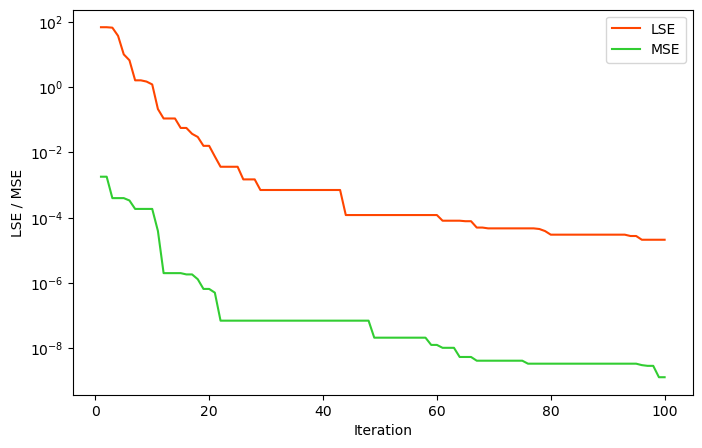

In [12]:
# plot convergence
fig = plt.figure(figsize=(8, 5))
# smooth the MSE & SSR
_mse = np.array(store[:,4].copy())
for i in range(1, len(_mse)): _mse[i] = min(_mse[i], _mse[i-1])  
_ssr = np.array(store[:,3].copy())
for i in range(1, len(_ssr)): _ssr[i] = min(_ssr[i], _ssr[i-1])  
plt.plot(store[:,0], _ssr, label='LSE', c='orangered');
plt.plot(store[:,0], _mse, label='MSE', c='limegreen');
plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('LSE / MSE'); plt.legend(); #plt.ylim(1e-10, 1e1);

In [13]:
# test sample (128x128)
xs = jnp.linspace(-1, 1, 128)
ys = jnp.linspace(-1, 1, 128)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
xy_bc = ((x == x_l) | (x == x_u) | (y == y_l) | (y == y_u)).flatten()
print ('#BC sample = %d'%xy_bc.sum())

# solution
def get_u(x, y, weights, w):
    f = get_f(x, y, weights)
    return (f @ w)

#BC sample = 508


In [14]:
@jit
def compute_ls_ntask(param, task):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # problem
    a1, a2, w1, w2, w3, w4 = test_task[task]
    u_bc = eval_u(x, y, a1, a2, w1, w2, w3, w4)
    #s_bc = ((x == x_l) | (x == x_u) | (y == y_l) | (y == y_u)).flatten()
    # PDE : (u_xx + u_yy) + u*(1 - u**2) = g
    f = f_vmap(x, y, weights)
    f_xx, f_yy = f_dir_vmap(get_f, x, y, weights)
    f_xx, f_yy = f_xx[:,:,0,0], f_yy[:,:,0,0]
    # first iteration - u0 = 0
    u0 = 0
    pde = (f_xx + f_yy) + f*(1 - u0**2)
    g = eval_g(x, y, a1, a2, w1, w2, w3, w4)
    # construct least square problem - populate A & b
    A = jnp.vstack([pde, f[xy_bc]])
    b = jnp.vstack([g, u_bc[xy_bc]])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    tot_iter = 5
    for i in range(tot_iter - 1):
        # update u0
        u0 = f @ w
        pde = (f_xx + f_yy) + f*(1 - u0**2)
        # update A
        A = jnp.vstack([pde, f[xy_bc]])
        # alternative solve (n_sample >> n_node & n_node >> n_sample)
        w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    # ssr, mse, rl2
    ssr = np.sum((b - A @ w)**2)
    u = f @ w
    mse = jnp.mean((u_bc - u)**2)
    rl2 = jnp.linalg.norm(u_bc - u) / jnp.linalg.norm(u_bc)
    return weights, w, ssr, mse, rl2

000  a1, a2, w1, w2, w3, w4 = (0.8, 0.4, 4.8, 1.1, 3.5, 1.4)    | SSR = 8.06e-04  MSE = 2.29e-09  RL2 = 9.55e-05
001  a1, a2, w1, w2, w3, w4 = (0.4, 0.7, 4.6, 2.3, 1.1, 3.6)    | SSR = 5.47e-04  MSE = 3.02e-09  RL2 = 1.13e-04
002  a1, a2, w1, w2, w3, w4 = (0.4, 0.6, 3.4, 2.5, 3.4, 2.4)    | SSR = 4.04e-04  MSE = 3.86e-09  RL2 = 1.14e-04
003  a1, a2, w1, w2, w3, w4 = (0.8, 0.4, 1.1, 2.7, 4.1, 4.6)    | SSR = 4.63e-03  MSE = 2.59e-08  RL2 = 4.22e-04
004  a1, a2, w1, w2, w3, w4 = (0.6, 0.5, 2.8, 4.6, 2.4, 3.3)    | SSR = 1.14e-03  MSE = 6.00e-09  RL2 = 1.07e-04


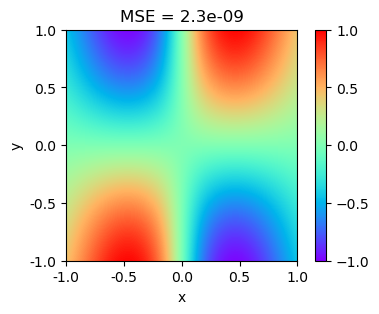

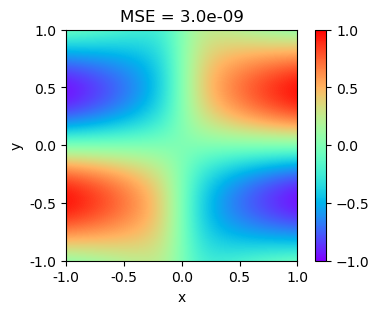

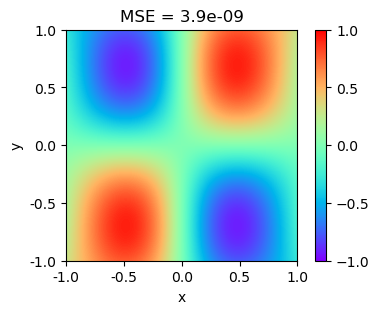

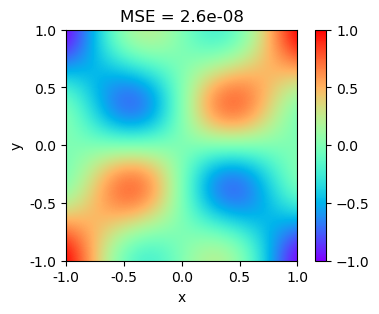

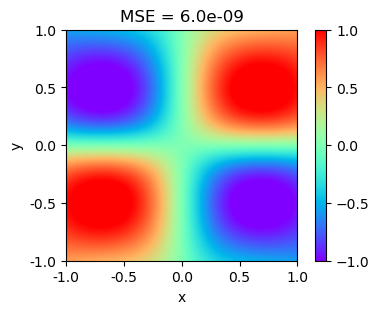

In [15]:
# plot selected task
for task in range(5):
    # problem
    a1, a2, w1, w2, w3, w4 = test_task[task]
    u_bc = eval_u(x, y, a1, a2, w1, w2, w3, w4)
    # solve problem
    weights, w, ssr, mse, rl2 = compute_ls_ntask(solver.best_params, task)
    u = get_u(x, y, weights, w)
    print('%03d  a1, a2, w1, w2, w3, w4 = (%.1f, %.1f, %.1f, %.1f, %.1f, %.1f)\
    | SSR = %.2e  MSE = %.2e  RL2 = %.2e'%(task, a1, a2, w1, w2, w3, w4, ssr, mse, rl2));
    
    # plot solution
    fig = plt.figure(figsize=(4.5, 3))
    ext = [x_l, x_u, y_l, y_u]     # plot boundary
    u_plot = u.reshape(128, -1)
    mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1., vmin=-1, vmax=1); 
    plt.colorbar(mesh2, ticks=jnp.linspace(-1, 1, 5)); plt.xlabel('x'); plt.ylabel('y');
    plt.xticks(jnp.linspace(-1, 1, 5), jnp.linspace(-1, 1, 5)); plt.yticks(jnp.linspace(-1, 1, 5), jnp.linspace(-1, 1, 5));
    plt.title('MSE = %.1e'%(mse)); 

In [16]:
# all test tasks
mses, rl2s = [], []
for task in range(len(test_task)):
    # problem
    a1, a2, w1, w2, w3, w4 = test_task[task]
    u_bc = eval_u(x, y, a1, a2, w1, w2, w3, w4)
    # solve problem
    weights, w, ssr, mse, rl2 = compute_ls_ntask(solver.best_params, task)
    u = get_u(x, y, weights, w)
#     print('%03d  a1, a2, w1, w2, w3, w4 = (%.1f, %.1f, %.1f, %.1f, %.1f, %.1f)\
#     | SSR = %.2e  MSE = %.2e  RL2 = %.2e'%(task, a1, a2, w1, w2, w3, w4, ssr, mse, rl2));
    mses.append(mse)
    rl2s.append(rl2)

mses, rl2s = jnp.array(mses), jnp.array(rl2s)
print (mses.mean(), mses.std()) 
print (rl2s.mean(), rl2s.std()) 

1.7433236985232858e-08 4.275395632863534e-08
0.00017824650465935477 0.00012737780614696184


006  a1, a2, w1, w2, w3, w4 = (0.5, 0.5, 4.0, 3.0, 4.8, 4.4)    | SSR = 1.02e-02  MSE = 7.32e-08  RL2 = 6.12e-04
035  a1, a2, w1, w2, w3, w4 = (0.8, 0.8, 4.0, 1.9, 3.6, 3.1)    | SSR = 1.90e-03  MSE = 1.28e-08  RL2 = 1.37e-04


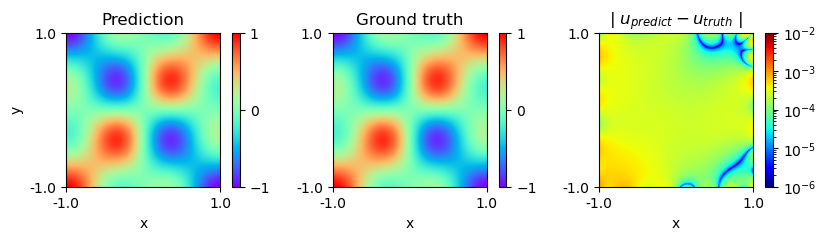

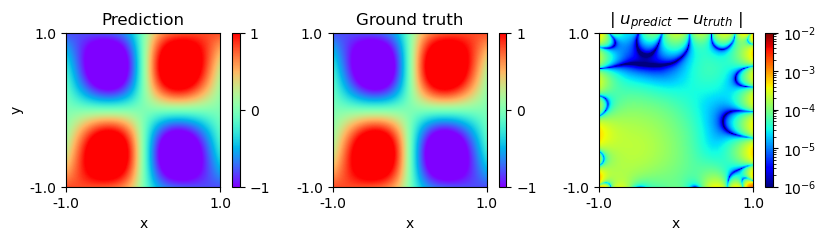

In [23]:
# plot selected task
pmax, pmed = jnp.argmax(rl2s), jnp.argwhere(rl2s == jnp.percentile(rl2s, 50, interpolation='nearest'))[0][0]
vtasks = [pmax, pmed]

for task in vtasks:
    # problem
    task = int(task)
    a1, a2, w1, w2, w3, w4 = test_task[task]
    u_bc = eval_u(x, y, a1, a2, w1, w2, w3, w4)
    # solve problem
    weights, w, ssr, mse, rl2 = compute_ls_ntask(solver.best_params, task)
    u = get_u(x, y, weights, w)
    print('%03d  a1, a2, w1, w2, w3, w4 = (%.1f, %.1f, %.1f, %.1f, %.1f, %.1f)\
    | SSR = %.2e  MSE = %.2e  RL2 = %.2e'%(task, a1, a2, w1, w2, w3, w4, ssr, mse, rl2));
    
    # plot solution
    fig = plt.figure(figsize=(10, 2.))
    plt.subplots_adjust(wspace=.1)
    ext = [x_l, x_u, y_l, y_u]     # plot boundary
    ax1 = fig.add_subplot(1,3,1)
    u_plot = u.reshape(128, -1)
    mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1., vmin=-1, vmax=1); 
    plt.colorbar(mesh2, ticks=jnp.linspace(-1, 1, 3)); plt.xlabel('x'); plt.ylabel('y');
    plt.xticks(jnp.linspace(-1, 1, 2), jnp.linspace(-1, 1, 2)); plt.yticks(jnp.linspace(-1, 1, 2), jnp.linspace(-1, 1, 2));
    plt.title('Prediction'); 
    ax1 = fig.add_subplot(1,3,2)
    u_plot = u_bc.reshape(128, -1)
    mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1., vmin=-1, vmax=1); 
    plt.colorbar(mesh2, ticks=jnp.linspace(-1, 1, 3)); plt.xlabel('x'); plt.ylabel(' ');
    plt.xticks(jnp.linspace(-1, 1, 2), jnp.linspace(-1, 1, 2)); plt.yticks(jnp.linspace(-1, 1, 2), jnp.linspace(-1, 1, 2));
    plt.title('Ground truth'); 
    ax1 = fig.add_subplot(1,3,3)
    u_plot = abs(u - u_bc).reshape(128, -1)
    mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='jet', extent=ext, aspect=1.,
                       norm=colors.LogNorm(vmin=1e-6, vmax=1e-2)); 
    plt.colorbar(mesh2); plt.xlabel('x'); plt.ylabel(' ');
    plt.xticks(jnp.linspace(-1, 1, 2), jnp.linspace(-1, 1, 2)); plt.yticks(jnp.linspace(-1, 1, 2), jnp.linspace(-1, 1, 2));
    plt.title(r'| $u_{predict} - u_{truth}$ |'); 